In [1]:
print("hello, world!")

hello, world!


In [ ]:
# system packages 
import os
import json

# internal packages 

# external packages
from openai import OpenAI
from dotenv import load_dotenv
from graphql import build_schema, parse
from jinja2 import Environment, FileSystemLoader

load_dotenv()
open_ai_api_key = os.getenv("OPENAI_API_KEY")

## GraphQL Schema Parsing

In [ ]:

with open('../assets/schemas/opensea/opensea_original_schema.graphql', 'r') as schema_file:
    schema_str = schema_file.read()

# TEMP: Try to parse the schema given the errors we are seeing
custom_definitions = '''
scalar BigDecimal
scalar BigInt

directive @entity on OBJECT
directive @dailySnapshot on OBJECT
directive @regularPolling on OBJECT
directive @derivedFrom on OBJECT
directive @transaction on OBJECT
'''

full_schema_str = custom_definitions + schema_str
schema = build_schema(full_schema_str)

for type_name, graphql_type in schema.type_map.items():
    if type_name.startswith('__'):
        continue  # Skip introspection types
    print(f"Type: {type_name}")
    for field_name, field in graphql_type.fields.items():
        print(f"  Field: {field_name} (type: {field.type})")

## LangGraph

In [ ]:
# import getpass
# import os

# if "OPENAI_API_KEY" not in os.environ:
#     os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")
# open_ai_api_key = os.environ["OPENAI_API_KEY"]

In [17]:
# from typing import Annotated

# from langchain_openai import OpenAI
# from typing_extensions import TypedDict

# from langgraph.graph import StateGraph
# from langgraph.graph.message import add_messages


# class State(TypedDict):
#     messages: Annotated[list, add_messages]


# graph_builder = StateGraph(State)


# llm = OpenAI(model="gpt-4")


# def chatbot(state: State):
#     return {"messages": [llm.invoke(state["messages"])]}

# graph_builder.add_node("chatbot", chatbot)
# graph_builder.set_entry_point("chatbot")
# graph_builder.set_finish_point("chatbot")
# graph = graph_builder.compile()

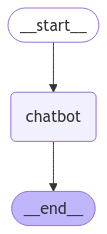

In [18]:
# from IPython.display import Image, display

# try:
#     display(Image(graph.get_graph().draw_mermaid_png()))
# except Exception:
#     pass

## OpenAI Directly

In [22]:
client = OpenAI(
    api_key=os.environ.get("OPENAI_API_KEY"),  # This is the default and can be omitted
)

def gpt_chat_completion(client, message, model="gpt-4o"):
    return client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": message,
        }
    ],
    model=model,
)

print(gpt_chat_completion(client, "Hello! How are you?").choices[0].message.content)

Hello! I'm just a computer program, so I don't have feelings, but I'm here to help you. How can I assist you today?


## Initial Test Set 

### Prompts 

- [ ] One entity quality vs. another entity quality 
- [ ] One column quality vs. another column quality 
- [ ] One schema quality vs. another schema quality 

### Demonstrations 

- [ ] A high quality entity (description)
- [ ] A high quality column (description)
- [ ] A high quality schema (description)

### Quality Categories

- [ ] 

In [ ]:
with open("tests/assets/entity_comparison_assets.json", "r") as f:
    entity_comparison_assets = json.load(f)

gold_entity_comparison = "".join(entity_comparison_assets["gold"]["prompt"])
four_entity_comparison = "".join(entity_comparison_assets["four"]["prompt"])
three_entity_comparison = "".join(entity_comparison_assets["three"]["prompt"])
two_entity_comparison = "".join(entity_comparison_assets["two"]["prompt"])
one_entity_comparison = "".join(entity_comparison_assets["one"]["prompt"])

In [35]:
env = Environment(loader=FileSystemLoader("../assets/prompts"))
entity_comparison_prompt_template = env.get_template("entity_comparison_prompt.txt")
gold_output = entity_comparison_prompt_template.render({"entity_pred": {gold_entity_comparison}, "entity_gold": {gold_entity_comparison}})
four_output = entity_comparison_prompt_template.render({"entity_pred": {four_entity_comparison}, "entity_gold": {gold_entity_comparison}})
three_output = entity_comparison_prompt_template.render({"entity_pred": {three_entity_comparison}, "entity_gold": {gold_entity_comparison}})
two_output = entity_comparison_prompt_template.render({"entity_pred": {two_entity_comparison}, "entity_gold": {gold_entity_comparison}})
one_output = entity_comparison_prompt_template.render({"entity_pred": {one_entity_comparison}, "entity_gold": {gold_entity_comparison}})

In [34]:
print(gpt_chat_completion(client, gold_output).choices[0].message.content)

```json
{
    "reasoning": "The task is to evaluate the quality of the provided documentation compared to an example of quality documentation for the same schema. Both the evaluation documentation and the gold documentation are virtually identical. Each field within the schema is described with accurate details, such as the entity it belongs to (i.e., the marketplace), and the expected data type. The descriptions are clear, concise, and devoid of ambiguity. They use proper grammatical structure, punctuation, and capitalization. Additionally, all key concepts and entities referenced are clearly identified, and no critical information is missing. Based on the criteria provided, both the evaluation documentation and the gold documentation match perfectly.",
    "correctness": 3
}
```


In [36]:
print(gpt_chat_completion(client, four_output).choices[0].message.content)

```json
{
    "reasoning": "The evaluation documentation provides detailed descriptions for each column of the MarketplaceDailySnapshot schema. It improves upon the gold documentation by providing additional context and clarity. For instance, the detailed structure of the 'id' is explicitly stated, describing the combination of contract address and the number of days since the Unix epoch time. This information is not present in the gold documentation. It elaborates more on descriptions, such as specifying 'the corresponding network' for the block number with 'from the corresponding network' in 'blockNumber' and 'timestamp', adding more detail about how the snapshot relates to the network it was taken on. Furthermore, it includes full, well-structured sentences with proper grammar, punctuation, and capitalization. The descriptions for fields like 'cumulativeTradeVolumeETH', 'marketplaceRevenueETH', 'creatorRevenueETH', etc., provide additional financial context about what these figures 

In [37]:
print(gpt_chat_completion(client, three_output).choices[0].message.content)

```json
{
  "reasoning": "To evaluate the quality of the EVALUATION DOCUMENTATION provided against the GOLD DOCUMENTATION, we need to compare each aspect of the documentation. Both documentations define a table schema of 'MarketplaceDailySnapshot.' Let's analyze each criterion:\n\n1. **Length Match:** Both the EVALUATION and GOLD documentations are identical in terms of the length and structure of descriptions provided for the columns.\n\n2. **Clarity and Completeness:** Both documentations provide clear, unambiguous full sentences for each field. Each description includes what the field represents, such as which marketplace the snapshot belongs to or the nature of the recorded metric, meeting the criteria for full and valid English sentences with proper grammar, capitalization, and punctuation.\n\n3. **Accuracy and Consistency:** The descriptions in both documentations are perfectly aligned. They mention relevant details like the role of cumulative and daily metrics in the context of 

In [38]:
print(gpt_chat_completion(client, two_output).choices[0].message.content)

```json
{
    "reasoning": "To evaluate the quality of the documentation provided in the 'EVALUATION DOCUMENTATION' against the 'GOLD DOCUMENTATION', let's analyze each column description in detail:\n\n1. 'id' field: Both documentations describe the 'id' field similarly. However, the GOLD documentation is slightly more precise by saying '{# of days since Unix epoch time}'. This detail slightly enhances understanding but isn't critical enough to drastically change interpretation.\n\n2. 'marketplace' field: The GOLD documentation adds 'that this snapshot belongs to' which provides context but isn't a major difference in the core understanding.\n\n3. 'blockNumber' field: GOLD documentation elaborates slightly by adding 'where the snapshot is taken', but this is implicit in both descriptions.\n\n4. 'timestamp' field: Similar wording with minor differences that don't significantly alter understanding.\n\n5. 'collectionCount' field: GOLD documentation explicitly specifies 'listed' which clar

In [39]:
print(gpt_chat_completion(client, one_output).choices[0].message.content)  

```json
{
    "reasoning": "The evaluation documentation provides descriptions for each column in the MarketplaceDailySnapshot table. To determine the quality of these descriptions, we can compare them against the gold documentation and assess them based on the evaluation criteria. \n\nFirstly, looking at the general structure, both sets of documentation appear to be describing similar concepts for each field in a similar order, but with notable differences in detail and clarity. The gold documentation, for instance, includes full sentences and contextual clues which enhance understanding, while the evaluation documentation often uses short, incomplete phrases, and lacks detailed explanations. \n\nEvaluating correctness step-by-step: \n\n1. For 'id', the gold documentation offers a composite description involving contract address and a timestamp context, while the evaluation documentation omits this level of detail by just labeling it with a reference to 'collections'. \n\n2. The descr